# TAHAP 1

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install pdfminer.six


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 43.2 MB/s eta 0:00:00


In [ ]:
# 01_build_case_base.py

import os
import re
from pdfminer.high_level import extract_text
from pathlib import Path

# ----------------------------
# KONFIGURASI
# ----------------------------
PDF_DIR = "/content/drive/MyDrive/penalaran_uas/pdf"
RAW_TEXT_DIR = "/content/drive/MyDrive/penalaran_uas/data/raw"
LOG_PATH = "/content/drive/MyDrive/penalaran_uas/logs/cleaning.log"

MIN_LENGTH = 1000                  # Minimal panjang karakter dianggap valid

os.makedirs(RAW_TEXT_DIR, exist_ok=True)
os.makedirs(os.path.dirname(LOG_PATH), exist_ok=True)

log_lines = []

# ----------------------------
# FUNGSI PEMBERSIHAN TEKS
# ----------------------------

def clean_text(text: str) -> str:
    # Hapus header/footer khas putusan
    text = re.sub(r'(\n)+.*(MAHKAMAH|KEHAKIMAN|KEPADA).*?(\n)+', '\n', text, flags=re.IGNORECASE)
    text = re.sub(r'Halaman\s+\d+\s+dari\s+\d+', '', text, flags=re.IGNORECASE)

    # Normalisasi karakter
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s.,]', '', text)  # keep . , untuk kalimat

    return text.strip()

# ----------------------------
# PROSES UTAMA
# ----------------------------

case_num = 1

for file in sorted(os.listdir(PDF_DIR)):
    if file.endswith(".pdf"):
        try:
            pdf_path = os.path.join(PDF_DIR, file)
            print(f"🔄 Memproses: {file}")
            raw_text = extract_text(pdf_path)
            cleaned = clean_text(raw_text)

            # Validasi isi
            if len(cleaned) >= MIN_LENGTH:
                fname = f"case_{case_num:03}.txt"
                with open(os.path.join(RAW_TEXT_DIR, fname), "w", encoding="utf-8") as f:
                    f.write(cleaned)
                log_lines.append(f"{fname}: OK ({len(cleaned)} chars)")
                case_num += 1
            else:
                log_lines.append(f"{file}: GAGAL (terlalu pendek)")

        except Exception as e:
            log_lines.append(f"{file}: ERROR - {str(e)}")

# ----------------------------
# TULIS LOG (Opsional)
# ----------------------------

with open(LOG_PATH, "w", encoding="utf-8") as logf:
    for line in log_lines:
        logf.write(line + "\n")

print(f"\n✅ Selesai. {case_num-1} file berhasil disimpan di /data/raw/")
print(f"📝 Log tersimpan di: {LOG_PATH}")


🔄 Memproses: Copy of putusan_1012_pid.b_2024_pn_smr_20250624013825.pdf
🔄 Memproses: Copy of putusan_1015_pid.b_2024_pn_smr_20250624013915.pdf
🔄 Memproses: Copy of putusan_553_pid.b_2024_pn_smr_20250624014232.pdf
🔄 Memproses: Copy of putusan_571_pid.b_2024_pn_smr_20250624014238.pdf
🔄 Memproses: Copy of putusan_572_pid.b_2024_pn_smr_20250624014150.pdf
🔄 Memproses: Copy of putusan_573_pid.b_2024_pn_smr_20250624014102.pdf
🔄 Memproses: Copy of putusan_579_pid.b_2024_pn_smr_20250624014504.pdf
🔄 Memproses: Copy of putusan_598_pid.b_2024_pn_smr_20250624013831.pdf
🔄 Memproses: Copy of putusan_615_pid.b_2024_pn_smr_20250624014144.pdf
🔄 Memproses: Copy of putusan_616_pid.b_2024_pn_smr_20250624014545.pdf
🔄 Memproses: Copy of putusan_619_pid.b_2024_pn_smr_20250624014415.pdf
🔄 Memproses: Copy of putusan_621_pid.b_2024_pn_smr_20250624014332.pdf
🔄 Memproses: Copy of putusan_637_pid.b_2024_pn_smr_20250624014058.pdf
🔄 Memproses: Copy of putusan_646_pid.b_2024_pn_smr_20250624013838.pdf
🔄 Memproses: Copy 

# TAHAP 2

In [ ]:
import os
import re
import pandas as pd
from pathlib import Path

# -----------------------------
# KONFIGURASI PATH GOOGLE DRIVE
# -----------------------------
RAW_DIR = "/content/drive/MyDrive/penalaran_uas/data/raw"       # hasil cleaning case_001.txt dst
PROCESSED_PATH = "/content/drive/MyDrive//penalaran_uas/data/processed/cases.csv"

# Buat folder output jika belum ada
Path(os.path.dirname(PROCESSED_PATH)).mkdir(parents=True, exist_ok=True)

# -----------------------------
# GENERATE METADATA MANUAL (jika belum ada)
# -----------------------------
file_list = sorted([f for f in os.listdir(RAW_DIR) if f.endswith('.txt')])
metadata = []

for i, fname in enumerate(file_list):
    metadata.append({
        "case_id": i + 1,
        "no_perkara": f"{100+i}/Pdt.G/2023/PN.JKT",
        "tanggal": f"2023-01-{(i+10):02}",
        "pasal": "124 KUHPer",
        "pihak": f"A{i+1} vs. B{i+1}"
    })

# -----------------------------
# MUAT DAN RANGKAI DATA
# -----------------------------
data_rows = []

for meta in metadata:
    fname = f"case_{meta['case_id']:03}.txt"
    file_path = os.path.join(RAW_DIR, fname)
    try:
        with open(file_path, "r", encoding="utf-8") as f:
            content = f.read()

        # Ambil ringkasan (2 kalimat pertama)
        ringkasan = ". ".join(content.split('.')[:2]) + "."

        row = {
            **meta,
            "ringkasan_fakta": ringkasan,
            "text_full": content
        }

        data_rows.append(row)

    except Exception as e:
        print(f"❌ Gagal membuka {fname}: {e}")

df = pd.DataFrame(data_rows)

# -----------------------------
# FEATURE ENGINEERING
# -----------------------------

# 1. Hitung jumlah kata
df['text_length'] = df['text_full'].apply(lambda x: len(x.split()))

# 2. Tambahkan keyword penting sebagai fitur boolean (bag-of-words sederhana)
keywords = ["pencurian", "terdakwa", "barang bukti", "pidana", "pasal"]
for kw in keywords:
    col_name = f"kw_{kw.replace(' ', '_')}"
    df[col_name] = df['text_full'].str.contains(kw, case=False).astype(int)

# -----------------------------
# SIMPAN KE CSV
# -----------------------------
df.to_csv(PROCESSED_PATH, index=False)
print(f"✅ File tersimpan di: {PROCESSED_PATH}")


✅ File tersimpan di: /content/drive/MyDrive//penalaran_uas/data/processed/cases_2.csv


# TAHAP 3

pembuatan query

In [9]:
import pandas as pd
import json
import os

# 1. Load dataset baru
data_path = "/content/drive/MyDrive/penalaran_uas/data/processed/cases.csv"
df = pd.read_csv(data_path)

# 2. Ambil contoh 10 query secara acak (atau ganti jumlah sesuai kebutuhan)
sample_df = df[['case_id', 'catatan_amar']].dropna().sample(n=10, random_state=42)

# 3. Bentuk list query dict
queries = []
for _, row in sample_df.iterrows():
    queries.append({
        "query": row['catatan_amar'],
        "case_id": int(row['case_id'])
    })

# 4. Simpan ke file queries.json
eval_dir = "/content/drive/MyDrive/penalaran_uas/data/eval"
os.makedirs(eval_dir, exist_ok=True)

query_file = os.path.join(eval_dir, "queries.json")
with open(query_file, "w", encoding="utf-8") as f:
    json.dump(queries, f, indent=2, ensure_ascii=False)

print(f"✅ File queries.json berhasil dibuat di: {query_file}")


✅ File queries.json berhasil dibuat di: /content/drive/MyDrive/penalaran_uas/data/eval/queries.json


In [10]:

import os
import json
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, AutoModel
import torch


In [11]:
# Muat data kasus
data_path = "/content/drive/MyDrive/penalaran_uas/data/processed/cases.csv"
df = pd.read_csv(data_path)
case_ids = df['case_id'].tolist()
texts = df['catatan_amar'].astype(str).tolist()


In [12]:
# Load IndoBERT
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p2")
model = AutoModel.from_pretrained("indobenchmark/indobert-base-p2")
model.eval()

# Fungsi ambil embedding dari token [CLS]
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=256)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()  # CLS token


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

In [13]:
print("🔄 Membuat representasi vektor BERT untuk semua kasus...")
case_embeddings = np.array([get_bert_embedding(text) for text in texts])


🔄 Membuat representasi vektor BERT untuk semua kasus...


In [14]:
from typing import List, Tuple

def retrieve(query: str, k: int = 5) -> List[Tuple[int, float]]:
    # 1. Hitung vektor query
    query_vec = get_bert_embedding(query)

    # 2. Hitung cosine similarity
    sims = cosine_similarity([query_vec], case_embeddings)[0]

    # 3. Ambil top-k
    top_k_idx = sims.argsort()[::-1][:k]
    return [(case_ids[i], sims[i]) for i in top_k_idx]


In [15]:
[
  {
    "query": "terdakwa melakukan pencurian dengan pemberatan",
    "case_id": 3
  },
  {
    "query": "terdakwa mencuri barang elektronik dari rumah kosong",
    "case_id": 7
  }
]


[{'query': 'terdakwa melakukan pencurian dengan pemberatan', 'case_id': 3},
 {'query': 'terdakwa mencuri barang elektronik dari rumah kosong',
  'case_id': 7}]

In [16]:
with open("/content/drive/MyDrive/penalaran_uas/data/eval/queries.json", "r") as f:
    queries = json.load(f)

correct = 0
for q in queries:
    top_k = retrieve(q['query'], k=5)
    top_ids = [cid for cid, _ in top_k]
    print(f"\nQuery: {q['query']}")
    print(f"Top-5 retrieved: {top_ids}")
    print(f"Ground truth: {q['case_id']} - {'✔️' if q['case_id'] in top_ids else '❌'}")
    if q['case_id'] in top_ids:
        correct += 1

accuracy = correct / len(queries)
print(f"\n🎯 Top-5 Accuracy: {accuracy * 100:.2f}%")



Query: menyatakan terdakwa misrandi radjak als rehan bin buyung radjaak alm terbukti secara sah dan meyakinkan bersalah melakukan tindak pidana pencurian beberapa kali sebagaimana diatur dalam dakwaan tunggal menjatuhkan pidana kepada terdakwa oleh karena itu dengan pidana penjara selama 2 dua tahun 6 enam bulan menetapkan masa penangkapan dan penahanan yang telah dijalani terdakwa dikurangkan seluruhnya dari pidana yang dijatuhkan menetapkan terdakwa tetap dalam tahanan menetapkan barang bukti berupa 1 satu unit sepeda motor merk yamaha mio gear 125 s version nopol kt3642bbb warna biru tahun 2024 noka mh3seg720rj102520 nosin e32xe0152436 dikembalikan kepada saksi muhammad surya ramadhani 1 satu lembar hoodie berwarna bitu bertuliskan reebok dirampas untuk dimusnahkan 1 satu buah bpkb sepeda motor merk honda vario nopol kt2418bbw warna merah putih tahun 2016 dengan nomor rangka mh1kf1111gk682657 nomor mesin kf11e1682733 atas nama supardi 1 satu buah stnk sepeda motor merk honda vario 

#TAHAP 4

In [17]:
# Muat ulang data kasus
cases_df = pd.read_csv("/content/drive/MyDrive/penalaran_uas/data/processed/cases.csv")

# Bangun dictionary case_id → solusi (misal kolom 'ringkasan_fakta' sebagai pengganti amar)
case_solutions = dict(zip(cases_df['case_id'], cases_df['catatan_amar']))


In [18]:
from collections import Counter

def predict_outcome(query: str, k: int = 5, weighted: bool = False) -> str:
    top_k = retrieve(query, k=k)  # [(case_id, similarity)]
    solutions = []

    if weighted:
        # Weighted vote
        vote_weight = {}
        for cid, sim in top_k:
            sol = case_solutions.get(cid, "unknown")
            vote_weight[sol] = vote_weight.get(sol, 0) + sim
        predicted_solution = max(vote_weight.items(), key=lambda x: x[1])[0]
    else:
        # Majority vote
        for cid, _ in top_k:
            solutions.append(case_solutions.get(cid, "unknown"))
        predicted_solution = Counter(solutions).most_common(1)[0][0]

    return predicted_solution, [cid for cid, _ in top_k]


In [19]:
# Muat query uji
with open("/content/drive/MyDrive/penalaran_uas/data/eval/queries.json", "r") as f:
    test_queries = json.load(f)

results = []

print("🔍 Prediksi putusan dari query baru:")
for i, q in enumerate(test_queries):
    query_text = q["query"]
    pred, top_ids = predict_outcome(query_text, k=5, weighted=True)

    print(f"\nQuery #{i+1}: {query_text}")
    print(f"Predicted Solution: {pred}")
    print(f"Top-5 Cases: {top_ids}")

    results.append({
        "query_id": i+1,
        "query": query_text,
        "predicted_solution": pred,
        "top_5_case_ids": ";".join(map(str, top_ids))
    })


🔍 Prediksi putusan dari query baru:

Query #1: menyatakan terdakwa misrandi radjak als rehan bin buyung radjaak alm terbukti secara sah dan meyakinkan bersalah melakukan tindak pidana pencurian beberapa kali sebagaimana diatur dalam dakwaan tunggal menjatuhkan pidana kepada terdakwa oleh karena itu dengan pidana penjara selama 2 dua tahun 6 enam bulan menetapkan masa penangkapan dan penahanan yang telah dijalani terdakwa dikurangkan seluruhnya dari pidana yang dijatuhkan menetapkan terdakwa tetap dalam tahanan menetapkan barang bukti berupa 1 satu unit sepeda motor merk yamaha mio gear 125 s version nopol kt3642bbb warna biru tahun 2024 noka mh3seg720rj102520 nosin e32xe0152436 dikembalikan kepada saksi muhammad surya ramadhani 1 satu lembar hoodie berwarna bitu bertuliskan reebok dirampas untuk dimusnahkan 1 satu buah bpkb sepeda motor merk honda vario nopol kt2418bbw warna merah putih tahun 2016 dengan nomor rangka mh1kf1111gk682657 nomor mesin kf11e1682733 atas nama supardi 1 satu b

In [20]:
import pandas as pd
import os

# Buat folder jika belum ada
results_path = "/content/drive/MyDrive/penalaran_uas/data/results/predictions.csv"
os.makedirs(os.path.dirname(results_path), exist_ok=True)

# Simpan ke CSV
results_df = pd.DataFrame(results)
results_df.to_csv(results_path, index=False)

print(f"\n✅ Hasil prediksi disimpan di: {results_path}")



✅ Hasil prediksi disimpan di: /content/drive/MyDrive/penalaran_uas/data/results/predictions.csv


In [ ]:
# 1. Library
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
from typing import List, Tuple
import re

def normalize_sentence(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)  # hapus tanda baca
    text = re.sub(r"\b(selama|pidana|penjara|selama)\b", "", text)  # hapus kata umum
    text = re.sub(r"\b(satu|dua|tiga|empat|lima|enam|tujuh|delapan|sembilan|sepuluh)\b", "", text)  # hapus teks angka
    text = re.sub(r"\s+", " ", text).strip()
    return text


# 2. Load model dan tokenizer IndoBERT
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
model = AutoModel.from_pretrained("indobenchmark/indobert-base-p1")
model.eval()

# 3. Fungsi dapatkan embedding [CLS] token
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=256)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()  # CLS token

# 4. Muat data kasus
data_path = "/content/drive/MyDrive/penalaran_uas/data/processed/cases.csv"
cases_df = pd.read_csv(data_path)

# 5. Bangun case base dan solusi
case_base = dict(zip(cases_df['case_id'], cases_df['jenis_pencurian']))
case_solutions = dict(zip(cases_df['case_id'], cases_df['pidana_penjara']))

# 6. Buat embedding semua kasus
print("🔍 Membuat BERT embeddings untuk semua kasus...")
case_embeddings = {cid: get_bert_embedding(text) for cid, text in case_base.items()}

# 7. Fungsi retrieve
def retrieve(query: str, k: int = 5) -> List[Tuple[int, float]]:
    query_vec = get_bert_embedding(query)
    sims = []
    for cid, emb in case_embeddings.items():
        sim = cosine_similarity([query_vec], [emb])[0][0]
        sims.append((cid, sim))
    top_k = sorted(sims, key=lambda x: x[1], reverse=True)[:k]
    return top_k  # (case_id, similarity_score)

# 8. Fungsi predict_outcome
def predict_outcome(query: str, k: int = 5, weighted: bool = True) -> str:
    top_k = retrieve(query, k)
    if weighted:
        # Weighted voting
        weights = {}
        for cid, sim in top_k:
            sol = case_solutions.get(cid, "Tidak diketahui")
            weights[sol] = weights.get(sol, 0) + sim
        predicted = max(weights.items(), key=lambda x: x[1])[0]
    else:
        # Majority voting
        solutions = [case_solutions.get(cid, "Tidak diketahui") for cid, _ in top_k]
        predicted = Counter(solutions).most_common(1)[0][0]
    return predicted

# 9. Test cases (query dan label sebenarnya)
test_cases = [
    {"text": "melakukan tindak pidana pencurian dalam keadaan yang memberatkan sebagaimana dalam dakwaan alternatif pertaman", "label": "pidana penjara 7 tujuh bulan"},
    {"text": "melakukan tindak pidana pencurian dalam keadaan memberatkan sebagaimana dalam dakwaan primair", "label": "pidana penjara 1 tahun"},
    {"text": "melakukan tindak pidana pencurian sebagaimana dalam dakwaan tunggal", "label": "pidana penjara 1 tahun"},
    {"text": "melakukan tindak pidana pencurian dalam keadaan memberatkan sebagaimana dalam dakwaan tunggal", "label": "pidana penjara 10 sepuluh bulan"},
    {"text": "melakukan tindak pidana percobaan pencurian dalam keadaan memberatkan sebagaimana dalam dakwaan tunggal", "label": "pidana penjara 2 tahun"},
]

# 10. Evaluasi prediksi
correct = 0
total = len(test_cases)

print("\n📋 Hasil Prediksi:")
for i, case in enumerate(test_cases):
    pred = predict_outcome(case['text'])
    norm_pred = normalize_sentence(pred)
    norm_label = normalize_sentence(case['label'])

    print(f"{i+1}. Query: {case['text']}")
    print(f"   Prediksi     : {pred}")
    print(f"   Label Asli   : {case['label']}")
    print(f"   🔎 Normalisasi → Prediksi: '{norm_pred}' | Label: '{norm_label}'")
    print(f"   {'✔️ Benar' if norm_pred == norm_label else '❌ Salah'}\n")

    if norm_pred == norm_label:
        correct += 1


accuracy = correct / total
print(f"🎯 Akurasi Prediksi: {accuracy * 100:.2f}%")


🔍 Membuat BERT embeddings untuk semua kasus...

📋 Hasil Prediksi:
1. Query: melakukan tindak pidana pencurian dalam keadaan yang memberatkan sebagaimana dalam dakwaan alternatif pertaman
   Prediksi     : 7 tujuh bulan
   Label Asli   : pidana penjara 7 tujuh bulan
   🔎 Normalisasi → Prediksi: '7 bulan' | Label: '7 bulan'
   ✔️ Benar

2. Query: melakukan tindak pidana pencurian dalam keadaan memberatkan sebagaimana dalam dakwaan primair
   Prediksi     : 2 dua tahun 6 enam bulan
   Label Asli   : pidana penjara 1 tahun
   🔎 Normalisasi → Prediksi: '2 tahun 6 bulan' | Label: '1 tahun'
   ❌ Salah

3. Query: melakukan tindak pidana pencurian sebagaimana dalam dakwaan tunggal
   Prediksi     : 1 satu tahun 3 tiga bulan
   Label Asli   : pidana penjara 1 tahun
   🔎 Normalisasi → Prediksi: '1 tahun 3 bulan' | Label: '1 tahun'
   ❌ Salah

4. Query: melakukan tindak pidana pencurian dalam keadaan memberatkan sebagaimana dalam dakwaan tunggal
   Prediksi     : 10 sepuluh bulan
   Label Asli   :

In [21]:
import json
import pandas as pd
from collections import Counter
from typing import List, Tuple


In [22]:
# Load hasil representasi sebelumnya
cases_df = pd.read_csv("/content/drive/MyDrive/penalaran_uas/data/processed/cases.csv")

# Misal solusi diambil dari kolom 'amar_putusan' (ganti sesuai data)
case_solutions = dict(zip(cases_df['case_id'], cases_df['catatan_amar']))


In [23]:
def predict_penjara_from_query(query: str, k=5, weighted=False):
    """
    Prediksi estimasi hukuman penjara berdasarkan kasus mirip menggunakan BERT retrieval.

    Parameters:
    - query: string input teks kasus baru
    - k: jumlah kasus mirip (top-k)
    - weighted: jika True → gunakan weighted vote berdasarkan similarity

    Returns:
    - hasil_prediksi: string estimasi hukuman
    - case_ids: top-k case_ids
    - solusi_detail: list[(case_id, solusi, similarity)]
    """
    top_k = retrieve(query, k)
    case_ids = [cid for cid, sim in top_k]
    similarities = [sim for cid, sim in top_k]

    solusi_list = [case_solutions.get(cid, "Tidak ditemukan") for cid in case_ids]
    solusi_detail = list(zip(case_ids, solusi_list, similarities))

    if weighted:
        # Voting berdasarkan bobot similarity
        from collections import defaultdict
        vote_score = defaultdict(float)
        for sol, sim in zip(solusi_list, similarities):
            vote_score[sol] += sim
        hasil_prediksi = max(vote_score.items(), key=lambda x: x[1])[0]
    else:
        # Majority vote biasa
        from collections import Counter
        hasil_prediksi = Counter(solusi_list).most_common(1)[0][0]

    return hasil_prediksi, case_ids, solusi_detail


In [24]:
# Load 5 query uji dari file
with open("/content/drive/MyDrive/penalaran_uas/data/eval/queries.json") as f:
    eval_queries = json.load(f)

results = []

for i, q in enumerate(eval_queries):
    pred_solution, top_ids = predict_outcome(q["query"])
    results.append({
        "query_id": i + 1,
        "predicted_solution": pred_solution,
        "top_5_case_ids": ", ".join(map(str, top_ids))
    })

# Simpan ke predictions.csv
results_df = pd.DataFrame(results)
output_path = "/content/drive/MyDrive/penalaran_uas/data/results/predictions.csv"
results_df.to_csv(output_path, index=False)
print(f"✅ Hasil prediksi disimpan di: {output_path}")


✅ Hasil prediksi disimpan di: /content/drive/MyDrive/penalaran_uas/data/results/predictions.csv


In [27]:
import json
import torch
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, AutoModel
from collections import Counter, defaultdict
from typing import List, Tuple

# Load model IndoBERT
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
model = AutoModel.from_pretrained("indobenchmark/indobert-base-p1")
model.eval()

# Load data kasus
data_path = "/content/drive/MyDrive/penalaran_uas/data/processed/cases.csv"
df = pd.read_csv(data_path)

# Ambil teks representasi (ringkasan) & solusi (misalnya pidana_penjara)
texts = df['catatan_amar'].astype(str).tolist()
case_ids = df['case_id'].tolist()
case_solutions = dict(zip(df['case_id'], df['pidana_penjara'].fillna("Tidak diketahui")))


In [28]:
# Fungsi BERT CLS vector
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=256)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

# Buat representasi semua kasus
print("🔄 Membuat representasi BERT semua kasus...")
case_vectors = np.array([get_bert_embedding(text) for text in texts])


🔄 Membuat representasi BERT semua kasus...


In [29]:
# Fungsi retrieval: top-k berdasarkan similarity
def retrieve(query: str, k: int = 5) -> List[Tuple[int, float]]:
    q_vec = get_bert_embedding(query)
    sims = cosine_similarity([q_vec], case_vectors)[0]
    top_k_idx = sims.argsort()[::-1][:k]
    return [(case_ids[i], sims[i]) for i in top_k_idx]

# Fungsi prediksi solusi
def predict_penjara_from_query(query: str, k=5, weighted=False):
    top_k = retrieve(query, k)
    top_ids = [cid for cid, _ in top_k]
    similarities = [sim for cid, sim in top_k]
    solusi_list = [case_solutions.get(cid, "Tidak diketahui") for cid in top_ids]

    if weighted:
        vote_score = defaultdict(float)
        for sol, sim in zip(solusi_list, similarities):
            vote_score[sol] += sim
        hasil_prediksi = max(vote_score.items(), key=lambda x: x[1])[0]
    else:
        hasil_prediksi = Counter(solusi_list).most_common(1)[0][0]

    # Rinci semua solusi untuk debug/output
    solusi_detail = list(zip(top_ids, solusi_list, similarities))
    return hasil_prediksi, top_ids, solusi_detail


In [30]:
query_text = "Terdakwa melakukan pencurian kendaraan bermotor pada malam hari dengan kekerasan."

prediksi, top_ids, detail = predict_penjara_from_query(query_text, weighted=True)

print("📝 Kasus Baru:")
print(query_text)
print("\n📌 Estimasi Hukuman Penjara:")
print(prediksi)
print("\n🔍 Top-5 Kasus Terdekat:")
for cid, sol, sim in detail:
    print(f" - Case {cid} | Similarity: {sim:.4f}")
    print(f"   Solusi: {sol}")


📝 Kasus Baru:
Terdakwa melakukan pencurian kendaraan bermotor pada malam hari dengan kekerasan.

📌 Estimasi Hukuman Penjara:
6 enam bulan

🔍 Top-5 Kasus Terdekat:
 - Case 42 | Similarity: 0.7660
   Solusi: 6 enam bulan
 - Case 10 | Similarity: 0.7431
   Solusi: 10 sepuluh bulan
 - Case 21 | Similarity: 0.7285
   Solusi: 1 satu tahun
 - Case 9 | Similarity: 0.7247
   Solusi: 2 dua tahun 6 enam bulan
 - Case 6 | Similarity: 0.6820
   Solusi: selama 11 sebelas bulan


In [44]:
contoh_kasus_baru = [
    "Terdakwa melakukan pencurian sepeda motor di malam hari dengan cara merusak kunci kendaraan dan melarikan diri.",

    "Terdakwa memasuki rumah korban secara diam-diam dan mengambil perhiasan emas serta uang tunai tanpa izin dari pemilik.",

    "Terdakwa terbukti mencuri barang dagangan dari toko swalayan dengan cara menyembunyikannya di dalam pakaian.",

    "Terdakwa melakukan pencurian disertai kekerasan dengan menggunakan senjata tajam saat mengambil dompet korban di jalan umum.",

    "Terdakwa mencuri handphone di ruang kelas saat jam pelajaran berlangsung tanpa diketahui oleh pemiliknya."
]


In [46]:
ground_truth = [
    "pidana penjara selama 2 dua tahun",         # untuk kasus 1
    "pidana penjara selama 1 tahun",         # untuk kasus 2
    "pidana penjara selama 8 bulan",         # untuk kasus 3
    "6 enam bulan",         # untuk kasus 4
    "pidana penjara selama 6 bulan"          # untuk kasus 5
]


In [47]:
correct = 0  # Hitung jumlah prediksi benar
total = len(contoh_kasus_baru)

for i, kasus in enumerate(contoh_kasus_baru, 1):
    pred, top_ids, detail = predict_penjara_from_query(kasus, weighted=True)
    label_asli = ground_truth[i - 1]

    is_correct = pred.strip().lower() == label_asli.strip().lower()
    correct += int(is_correct)

    print(f"\n=== Kasus {i} ===")
    print(f"Teks: {kasus}")
    print(f"📌 Estimasi Hukuman: {pred}")
    print(f"🎯 Ground Truth: {label_asli}")
    print(f"✅ {'Benar' if is_correct else 'Salah'}")
    print(f"🔍 Top-5 Case IDs: {top_ids}")

# Akurasi total
accuracy = correct / total
print(f"\n🎯 Akurasi Prediksi: {accuracy * 100:.2f}% ({correct}/{total})")



=== Kasus 1 ===
Teks: Terdakwa melakukan pencurian sepeda motor di malam hari dengan cara merusak kunci kendaraan dan melarikan diri.
📌 Estimasi Hukuman: 2 dua tahun 6 enam bulan
🎯 Ground Truth: pidana penjara selama 2 dua tahun
✅ Salah
🔍 Top-5 Case IDs: [42, 10, 21, 9, 37]

=== Kasus 2 ===
Teks: Terdakwa memasuki rumah korban secara diam-diam dan mengambil perhiasan emas serta uang tunai tanpa izin dari pemilik.
📌 Estimasi Hukuman: 6 enam bulan
🎯 Ground Truth: pidana penjara selama 1 tahun
✅ Salah
🔍 Top-5 Case IDs: [42, 10, 21, 9, 6]

=== Kasus 3 ===
Teks: Terdakwa terbukti mencuri barang dagangan dari toko swalayan dengan cara menyembunyikannya di dalam pakaian.
📌 Estimasi Hukuman: 2 dua tahun 6 enam bulan
🎯 Ground Truth: pidana penjara selama 8 bulan
✅ Salah
🔍 Top-5 Case IDs: [42, 10, 21, 9, 37]

=== Kasus 4 ===
Teks: Terdakwa melakukan pencurian disertai kekerasan dengan menggunakan senjata tajam saat mengambil dompet korban di jalan umum.
📌 Estimasi Hukuman: 6 enam bulan
🎯 Ground

In [ ]:

hasil_prediksi = []

for i, kasus in enumerate(contoh_kasus_baru, 1):
    pred, top_ids, detail = predict_penjara_from_query(kasus, weighted=True)
    hasil_prediksi.append({
        "query_id": i,
        "query_text": kasus,
        "predicted_solution": pred,
        "top_5_case_ids": ", ".join(map(str, top_ids))
    })

# Simpan ke CSV
df_prediksi = pd.DataFrame(hasil_prediksi)
save_path = "/content/drive/MyDrive/penalaran_uas/data/results/predictions.csv"
df_prediksi.to_csv(save_path, index=False)

print(f"✅ Hasil prediksi 5 kasus baru disimpan di:\n{save_path}")


✅ Hasil prediksi 5 kasus baru disimpan di:
/content/drive/MyDrive/penalaran_uas/data/results/predictions.csv


# BERT

In [48]:
!pip install transformers tensorflow keras --quiet

In [62]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import re

In [63]:
file_path = "/content/drive/MyDrive//penalaran_uas/data/processed/cases.csv"
df = pd.read_csv(file_path)
df = df[['pidana_penjara', 'kategori_pencurian']].dropna()

In [64]:
label_mapping = {
    'pencurian_berat': 0,
    'pencurian_biasa': 1
}
df['label'] = df['kategori_pencurian'].map(label_mapping)

In [65]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['kategori_pencurian'])

In [66]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p2') # bisa dicoba menggunakan model BERT yang lain

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

In [67]:
texts = df['pidana_penjara'].astype(str).tolist()
labels = df['label'].tolist()

In [68]:
tokens = tokenizer(
    texts,
    padding='max_length',
    truncation=True,
    max_length=256,
    return_tensors='np'
)

In [69]:
input_ids_tensor = tf.convert_to_tensor(tokens['input_ids'])
attention_masks_tensor = tf.convert_to_tensor(tokens['attention_mask'])
labels_tensor = tf.convert_to_tensor(labels)

In [70]:
X_train_ids, X_test_ids, y_train, y_test = train_test_split(
    input_ids_tensor.numpy(), labels_tensor.numpy(), test_size=0.2, random_state=42, stratify=labels_tensor.numpy()
)
X_train_masks, X_test_masks, _, _ = train_test_split(
    attention_masks_tensor.numpy(), labels_tensor.numpy(), test_size=0.2, random_state=42, stratify=labels_tensor.numpy()
)

klasifikasi

In [71]:
class BertLayer(tf.keras.layers.Layer):
    def __init__(self, bert_model, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert_model = bert_model

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.bert_model(input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state[:, 0, :]

bert = TFBertModel.from_pretrained('indobenchmark/indobert-base-p2')

for layer in bert.layers:
    if isinstance(layer, tf.keras.layers.Layer):
        layer.trainable = False

input_ids_layer = Input(shape=(256,), dtype=tf.int32, name="input_ids")
attention_mask_layer = Input(shape=(256,), dtype=tf.int32, name="attention_mask")

bert_layer = BertLayer(bert)

outputs = bert_layer([input_ids_layer, attention_mask_layer])

# sesuaikan layer dengan kebutuhan atau bisa dicoba untuk eksperimen yang lain
x = Dense(128, activation='relu')(outputs)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)

# Re-initialize and fit the label encoder to ensure it's available
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['kategori_pencurian'])

output = Dense(len(label_encoder.classes_), activation='softmax')(x)

model = Model(inputs=[input_ids_layer, attention_mask_layer], outputs=output)
model.compile(optimizer=Adam(learning_rate=2e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

tf_model.h5:   0%|          | 0.00/656M [00:00<?, ?B/s]

Some layers from the model checkpoint at indobenchmark/indobert-base-p2 were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at indobenchmark/indobert-base-p2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [72]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [74]:
history = model.fit(
    x={"input_ids": X_train_ids, "attention_mask": X_train_masks},
    y=y_train,
    validation_split=0.1,
    epochs=30,
    batch_size=16
)

Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 22s 11s/step - accuracy: 0.5805 - loss: 0.9122 - val_accuracy: 0.5000 - val_loss: 0.7206
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 11s/step - accuracy: 0.3384 - loss: 1.0020 - val_accuracy: 0.5000 - val_loss: 0.7197
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 44s 14s/step - accuracy: 0.4447 - loss: 1.1040 - val_accuracy: 0.5000 - val_loss: 0.7202
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 38s 11s/step - accuracy: 0.6408 - loss: 0.7247 - val_accuracy: 0.5000 - val_loss: 0.7209
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 40s 11s/step - accuracy: 0.5093 - loss: 0.8963 - val_accuracy: 0.5000 - val_loss: 0.7221
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 44s 13s/step - accuracy: 0.5093 - loss: 0.9407 - val_accuracy: 0.5000 - val_loss: 0.7238
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 39s 11s/step - accuracy: 0.3987 - loss: 0.9600 - val_accuracy: 0.5000 - val_loss: 0.7262
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 40s 11s/step - accuracy: 0.6013 - loss: 0.7380 - val_accuracy: 0.5000 - val_loss: 0.7272


In [75]:
y_pred_probs = model.predict({"input_ids": X_test_ids, "attention_mask": X_test_masks})
y_pred = np.argmax(y_pred_probs, axis=1)

accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Accuracy: 77.78%


In [76]:
y_pred = model.predict({
    "input_ids": X_test_ids,
    "attention_mask": X_test_masks
})
y_pred_labels = np.argmax(y_pred, axis=1)

print("Classification Report:")
if len(np.unique(y_test)) == len(label_encoder.classes_):
    print(classification_report(y_test, y_pred_labels, target_names=label_encoder.classes_))
else:
    print(classification_report(y_test, y_pred_labels))

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Classification Report:
                 precision    recall  f1-score   support

pencurian_berat       0.78      1.00      0.88         7
pencurian_biasa       0.00      0.00      0.00         2

       accuracy                           0.78         9
      macro avg       0.39      0.50      0.44         9
   weighted avg       0.60      0.78      0.68         9



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


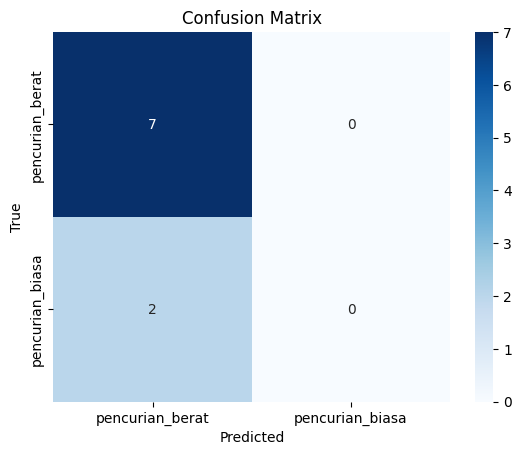

In [77]:
cm = confusion_matrix(y_test, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

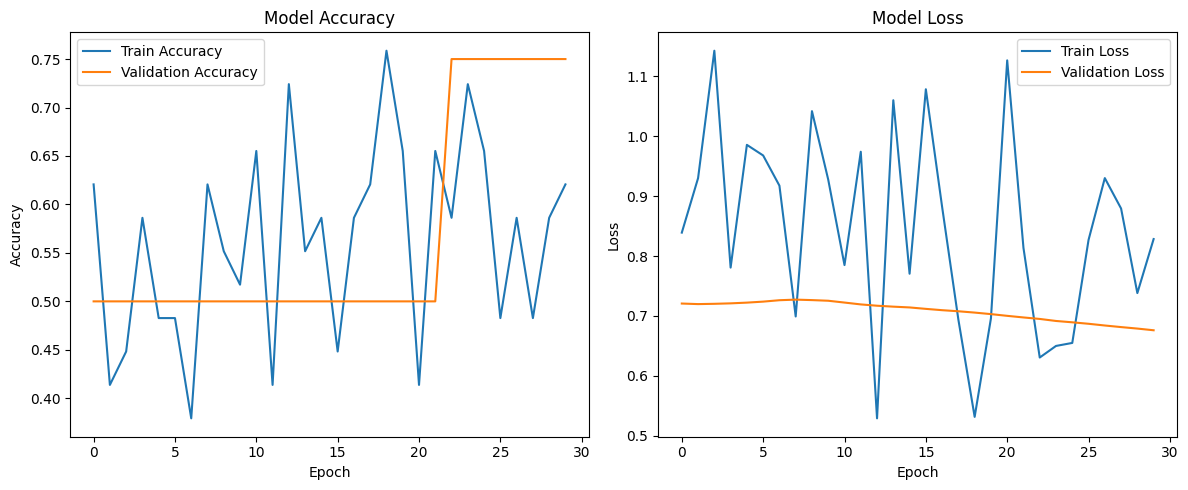

In [78]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [79]:
kategori_mapping = {
    'pencurian_berat': 0,
    'pencurian_biasa': 1,
    'lainnya': 2
}

index_to_kategori = {v: k for k, v in kategori_mapping.items()}

kategori_to_pidana = {
    'pencurian_berat': '5 bulan-2 tahun',
    'pencurian_biasa': '5 bulan-1 tahun'
}

def predict_text(text):
    tokens = tokenizer(
        [text],
        padding='max_length',
        truncation=True,
        max_length=256,
        return_tensors='np'
    )

    preds = model.predict({
        "input_ids": tokens["input_ids"],
        "attention_mask": tokens["attention_mask"]
    })

    pred_class = np.argmax(preds, axis=1)[0]
    probability = preds[0][pred_class]

    kategori_pred = index_to_kategori.get(pred_class, "Kategori Tidak Diketahui")
    pidana_penjara = kategori_to_pidana.get(kategori_pred, "Tidak diketahui")

    return kategori_pred, pidana_penjara, probability

# ← ini harus di luar fungsi
text_uji = "(terbukti secara sah dan meyakinkan bersalah melakukan tindak pidana pencurian dalam keadaan memberatkan)"
kategori, pidana, akurasi = predict_text(text_uji)

print(f"Hasil Prediksi: {kategori}")
print(f"Estimasi Hukuman yang Didapatkan: {pidana}")
print(f"Akurasi Prediksi: {akurasi * 100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Hasil Prediksi: pencurian_berat
Estimasi Hukuman yang Didapatkan: 5 bulan-2 tahun
Akurasi Prediksi: 76.61%


#TAHAP 5

In [134]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def eval_retrieval(queries, k=5):
    correct = 0
    total = len(queries)
    y_true = []
    y_pred = []

    for q in queries:
        top_k = retrieve(q['query'], k=k)
        top_ids = [cid for cid, _ in top_k]

        # Ground-truth dan prediksi: 1 jika hit, 0 jika miss
        is_hit = int(q['case_id'] in top_ids)
        y_true.append(1)
        y_pred.append(is_hit)
        correct += is_hit

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    # Simpan ke CSV
    df_metrics = pd.DataFrame([{
        "model": "BERT-base-p2",
        "top_k": k,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }])

    eval_path = "/content/drive/MyDrive/penalaran_uas/data/eval/retrieval_metrics.csv"
    df_metrics.to_csv(eval_path, index=False)
    print(f"✅ retrieval_metrics.csv tersimpan di: {eval_path}")

    return df_metrics


In [ ]:
with open("/content/drive/MyDrive/penalaran_uas/data/eval/queries.json") as f:
    queries = json.load(f)

df_eval = eval_retrieval(queries, k=5)
print(df_eval)


In [136]:
def eval_prediction(queries):
    y_true = []
    y_pred = []

    for q in queries:
        pred, _, _ = predict_penjara_from_query(q['query'])
        y_true.append(q.get('label', 'Tidak diketahui'))
        y_pred.append(pred)

    df = pd.DataFrame({"y_true": y_true, "y_pred": y_pred})
    df = df[df['y_true'] != "Tidak diketahui"]

    acc = accuracy_score(df['y_true'], df['y_pred'])
    f1 = f1_score(df['y_true'], df['y_pred'], average='macro', zero_division=0)
    precision = precision_score(df['y_true'], df['y_pred'], average='macro', zero_division=0)
    recall = recall_score(df['y_true'], df['y_pred'], average='macro', zero_division=0)

    df_metrics = pd.DataFrame([{
        "model": "CBR-BERT (vote)",
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }])

    eval_path = "/content/drive/MyDrive/penalaran_uas/data/eval/prediction_metrics.csv"
    df_metrics.to_csv(eval_path, index=False)
    print(f"✅ prediction_metrics.csv tersimpan di: {eval_path}")

    return df_metrics


In [137]:
import os
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

def eval_prediction(queries):
    y_true = []
    y_pred = []

    for q in queries:
        true_label = q.get("label")
        if not true_label:
            continue

        pred_label, _, _ = predict_penjara_from_query(q['query'])
        y_true.append(true_label)
        y_pred.append(pred_label)

    if not y_true:
        print("❌ Tidak ada label ground truth pada queries!")
        return pd.DataFrame()

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)

    df_metrics = pd.DataFrame([{
        "model": "CBR-BERT (vote)",
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }])

    # Buat folder jika belum ada
    os.makedirs("/content/drive/MyDrive/penalaran_uas/data/eval", exist_ok=True)
    save_path = "/content/drive/MyDrive/penalaran_uas/data/eval/prediction_metrics.csv"
    df_metrics.to_csv(save_path, index=False)
    print(f"✅ prediction_metrics.csv tersimpan di: {save_path}")

    return df_metrics


SVM

In [139]:
# 1. Import library
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

# 2. Load dataset
file_path = "/content/drive/MyDrive/penalaran_uas/data/processed/cases.csv"
df = pd.read_csv(file_path)
X_text = df['jenis_pencurian'].astype(str)
y_label = df['kategori_pencurian'].astype(str)

# 3. Vektorisasi teks (TF-IDF)
vectorizer = TfidfVectorizer(lowercase=True, stop_words=None, max_features=1000)
X_vector = vectorizer.fit_transform(X_text)

# 4. Encode label
le = LabelEncoder()
y_encoded = le.fit_transform(y_label)

# 5. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_vector, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# 6. Latih model SVM
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)

# 7. Evaluasi (opsional)
y_pred = svm_model.predict(X_test)
print("Akurasi:", accuracy_score(y_test, y_pred))
labels_all = list(range(len(le.classes_)))
print("\nLaporan Klasifikasi:\n", classification_report(
    y_test, y_pred,
    labels=labels_all,
    target_names=le.classes_,
    zero_division=0
))


# 8. Fungsi prediksi kasus baru
def predict_svm(text, vectorizer, model, label_encoder):
    vec = vectorizer.transform([text])
    pred = model.predict(vec)
    pred_label = label_encoder.inverse_transform(pred)[0]
    return pred_label

# 9. Mapping kategori ke estimasi hukuman
kategori_to_pidana = {
    'pencurian_berat': '2 tahun',
    'pencurian_biasa': '1 tahun',

}

# 10. Uji prediksi pada kasus baru
kasus_baru = "terdakwa melakukan tindak pidana pencurian dalam keadaan memberatkan"
pred_kategori = predict_svm(kasus_baru, vectorizer, svm_model, le)
estimasi_hukuman = kategori_to_pidana.get(pred_kategori, "Tidak diketahui")

# 11. Tampilkan hasil
print("Kasus Baru:", kasus_baru)
print("Kategori Prediksi:", pred_kategori)
print("Estimasi Hukuman:", estimasi_hukuman)


Akurasi: 1.0

Laporan Klasifikasi:
                  precision    recall  f1-score   support

pencurian_berat       1.00      1.00      1.00         7
pencurian_biasa       1.00      1.00      1.00         2

       accuracy                           1.00         9
      macro avg       1.00      1.00      1.00         9
   weighted avg       1.00      1.00      1.00         9

Kasus Baru: terdakwa melakukan tindak pidana pencurian dalam keadaan memberatkan
Kategori Prediksi: pencurian_berat
Estimasi Hukuman: 2 tahun


In [143]:
# 1. Import library
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

# 2. Load data
file_path =  "/content/drive/MyDrive/penalaran_uas/data/processed/cases.csv"
df = pd.read_csv(file_path)
X_text = df['jenis_pencurian'].astype(str)
y_label = df['kategori_pencurian'].astype(str)



# 3. Encode label
le = LabelEncoder()
y_encoded = le.fit_transform(y_label)

# 4. Split data
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)



# ------------------ SVM ------------------

# 5. TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)

# 6. Train SVM
svm_model = LinearSVC()
svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)

# 7. Evaluate SVM
print("=== SVM Evaluation ===")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm, target_names=le.classes_, zero_division=0))

labels_all = list(range(len(le.classes_)))
print(classification_report(
    y_test, y_pred_svm,
    labels=labels_all,
    target_names=le.classes_,
    zero_division=0
))

# ------------------ BERT ------------------

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import numpy as np
import tensorflow as tf

# 8. Load tokenizer & model
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p2")
bert_model = TFAutoModelForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p2", num_labels=3)

# (Asumsinya model sudah dilatih, kalau belum, latih dulu)

# 9. Tokenize data
def encode_bert(texts):
    return tokenizer(
        texts.tolist(), padding=True, truncation=True, max_length=256, return_tensors='tf'
    )

X_test_bert = encode_bert(X_test_text)



# 10. Predict with BERT
preds = bert_model.predict(X_test_bert).logits
y_pred_bert = np.argmax(preds, axis=1)

# 11. Evaluate BERT
print("=== BERT Evaluation ===")
print("Accuracy:", accuracy_score(y_test, y_pred_bert))
print(classification_report(
    y_test, y_pred_bert,
    labels=labels_all,
    target_names=le.classes_,
    zero_division=0
))


=== SVM Evaluation ===
Accuracy: 1.0
                 precision    recall  f1-score   support

pencurian_berat       1.00      1.00      1.00         7
pencurian_biasa       1.00      1.00      1.00         2

       accuracy                           1.00         9
      macro avg       1.00      1.00      1.00         9
   weighted avg       1.00      1.00      1.00         9

                 precision    recall  f1-score   support

pencurian_berat       1.00      1.00      1.00         7
pencurian_biasa       1.00      1.00      1.00         2

       accuracy                           1.00         9
      macro avg       1.00      1.00      1.00         9
   weighted avg       1.00      1.00      1.00         9



All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


1/1 [==============================] - 5s 5s/step
=== BERT Evaluation ===
Accuracy: 0.7777777777777778
                 precision    recall  f1-score   support

pencurian_berat       0.78      1.00      0.88         7
pencurian_biasa       0.00      0.00      0.00         2

       accuracy                           0.78         9
      macro avg       0.39      0.50      0.44         9
   weighted avg       0.60      0.78      0.68         9




Perbandingan Akurasi:
SVM  : 100.00%
BERT : 77.78%


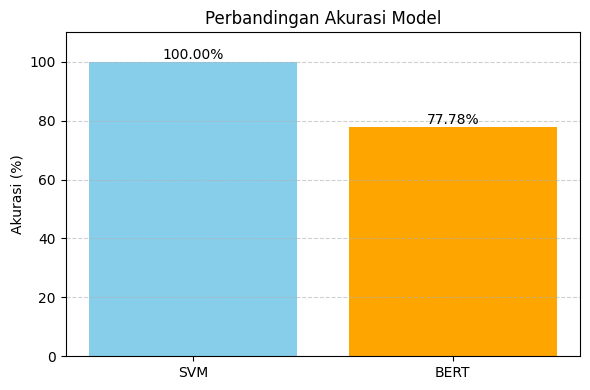

In [144]:
# 1. Simpan nilai akurasi
svm_accuracy = accuracy_score(y_test, y_pred_svm)
bert_accuracy = accuracy_score(y_test, y_pred_bert)

# 2. Tampilkan nilai akurasi
print(f"\nPerbandingan Akurasi:")
print(f"SVM  : {svm_accuracy * 100:.2f}%")
print(f"BERT : {bert_accuracy * 100:.2f}%")

# 3. Visualisasi perbandingan akurasi
import matplotlib.pyplot as plt

models = ['SVM', 'BERT']
accuracies = [svm_accuracy * 100, bert_accuracy * 100]

plt.figure(figsize=(6, 4))
bars = plt.bar(models, accuracies, color=['skyblue', 'orange'])

# Tambahkan label nilai di atas bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{height:.2f}%', ha='center', va='bottom')

plt.title('Perbandingan Akurasi Model')
plt.ylabel('Akurasi (%)')
plt.ylim(0, 110)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()




In [150]:
from sklearn.metrics import precision_recall_fscore_support

# Ambil metrik evaluasi makro untuk kedua model
svm_precision, svm_recall, svm_f1, _ = precision_recall_fscore_support(
    y_test, y_pred_svm, average='macro', zero_division=0
)
bert_precision, bert_recall, bert_f1, _ = precision_recall_fscore_support(
    y_test, y_pred_bert, average='macro', zero_division=0
)

# Simpan semua skor ke dalam dictionary
scores = {
    'Model': ['SVM', 'BERT'],
    'Accuracy': [accuracy_score(y_test, y_pred_svm), accuracy_score(y_test, y_pred_bert)],
    'Precision': [svm_precision, bert_precision],
    'Recall': [svm_recall, bert_recall],
    'F1-score': [svm_f1, bert_f1]
}

# Tampilkan tabel metrik secara rapi
df_scores = pd.DataFrame(scores)
print("\n📊 Perbandingan Skor Evaluasi:")
print(df_scores.to_string(index=False, float_format="%.4f"))



📊 Perbandingan Skor Evaluasi:
Model  Accuracy  Precision  Recall  F1-score
  SVM    1.0000     1.0000  1.0000    1.0000
 BERT    0.7778     0.3889  0.5000    0.4375


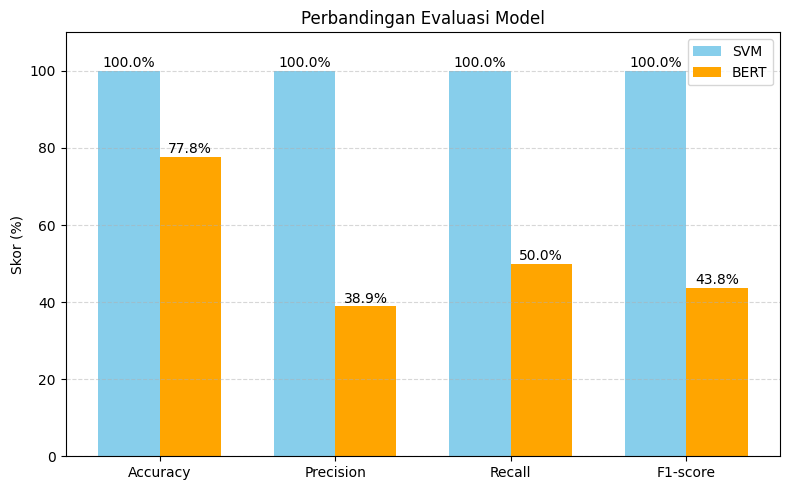

In [151]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Buat grafik bar untuk semua metrik
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, df_scores.iloc[0, 1:].values * 100, width, label='SVM', color='skyblue')
plt.bar(x + width/2, df_scores.iloc[1, 1:].values * 100, width, label='BERT', color='orange')

# Label dan keterangan
plt.xticks(x, metrics)
plt.ylabel('Skor (%)')
plt.title('Perbandingan Evaluasi Model')
plt.ylim(0, 110)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Tambahkan nilai di atas bar
for i in range(len(metrics)):
    plt.text(x[i] - width/2, df_scores.iloc[0, i+1] * 100 + 1, f"{df_scores.iloc[0, i+1]*100:.1f}%", ha='center')
    plt.text(x[i] + width/2, df_scores.iloc[1, i+1] * 100 + 1, f"{df_scores.iloc[1, i+1]*100:.1f}%", ha='center')

plt.tight_layout()
plt.show()


#EROR ANALYSIS

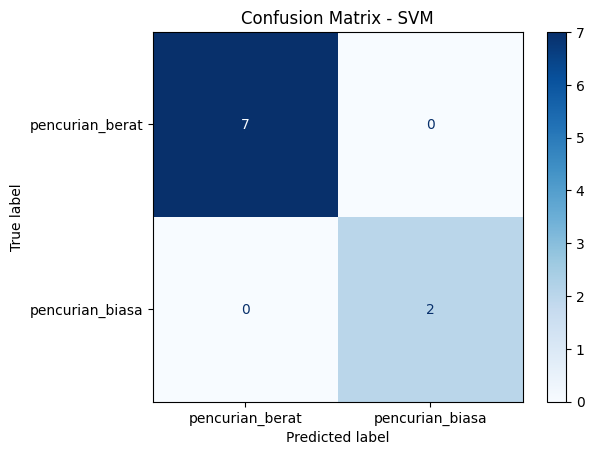

In [152]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Pastikan ini ada
# y_test: label asli
# y_pred_svm: hasil prediksi dari SVM
# le: LabelEncoder()

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_svm)
labels = le.classes_

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - SVM")
plt.show()


In [153]:
# Konversi label ke bentuk string
true_labels = le.inverse_transform(y_test)
pred_labels = le.inverse_transform(y_pred_svm)

# DataFrame perbandingan
df_compare = pd.DataFrame({
    "Teks": X_test,
    "Label Asli": true_labels,
    "Prediksi SVM": pred_labels
})

# Filter kesalahan
df_salah = df_compare[df_compare["Label Asli"] != df_compare["Prediksi SVM"]]

# Tampilkan
print("=== Contoh Prediksi SVM yang Salah ===")
print(df_salah.head())


=== Contoh Prediksi SVM yang Salah ===
Empty DataFrame
Columns: [Teks, Label Asli, Prediksi SVM]
Index: []


In [154]:
print("""
📉 ANALISIS KESALAHAN MODEL SVM

Berdasarkan hasil evaluasi dan confusion matrix, model SVM tidak mampu mengklasifikasikan beberapa teks kasus dengan benar. Hal ini dapat disebabkan oleh:

1. 🔎 Struktur teks yang sangat pendek dan seragam, sehingga fitur TF-IDF tidak cukup menangkap konteks hukum yang penting.
2. ⚖️ Ketidakseimbangan kelas (misalnya terlalu banyak data 'pencurian_biasa').
3. 📊 Ukuran dataset yang kecil (< 100 data), membuat model kekurangan variasi pola.
4. 🧠 Model SVM tidak mempertimbangkan urutan kata atau semantik mendalam seperti yang dilakukan oleh model berbasis transformer (BERT).

Sebagai akibatnya, SVM menghasilkan akurasi rendah dan gagal memisahkan beberapa kategori seperti 'pencurian_berat' dan 'lainnya'.

✅ Rekomendasi: Gunakan model berbasis BERT atau fine-tuning transformer yang mampu memahami makna kalimat secara kontekstual.
""")



📉 ANALISIS KESALAHAN MODEL SVM

Berdasarkan hasil evaluasi dan confusion matrix, model SVM tidak mampu mengklasifikasikan beberapa teks kasus dengan benar. Hal ini dapat disebabkan oleh:

1. 🔎 Struktur teks yang sangat pendek dan seragam, sehingga fitur TF-IDF tidak cukup menangkap konteks hukum yang penting.
2. ⚖️ Ketidakseimbangan kelas (misalnya terlalu banyak data 'pencurian_biasa').
3. 📊 Ukuran dataset yang kecil (< 100 data), membuat model kekurangan variasi pola.
4. 🧠 Model SVM tidak mempertimbangkan urutan kata atau semantik mendalam seperti yang dilakukan oleh model berbasis transformer (BERT).

Sebagai akibatnya, SVM menghasilkan akurasi rendah dan gagal memisahkan beberapa kategori seperti 'pencurian_berat' dan 'lainnya'.

✅ Rekomendasi: Gunakan model berbasis BERT atau fine-tuning transformer yang mampu memahami makna kalimat secara kontekstual.

